# Coresets with DPPs

In [3]:
import numpy as np
# import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib widget
%matplotlib inline
%load_ext autoreload 
%autoreload 2
# some highlight keywords by VSCode: TODO, FIXME, BUG, XXX, HACK, NOTE 

import sys
sys.path.append("DPPcoresets/src/")
from utils import set_plotting_options
set_plotting_options(usetex=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Function for estimating the Jacobi parameters
def generate_Jacobi_parameters(X):
## Method 1, to satisfy the first and second moment of the empirical distribution of X
    mu1 = X.mean(axis=0)
    Xs = X * X
    mu2 = Xs.mean(axis=0)
    tmp = (mu1 + 1) / 2 + (mu2 - 1) / 4 - (mu1 + 1) * (mu1 + 1) / 4
    t = (1 - mu1) / 2 * ((1 + mu1) * (1 - mu1) / 4 / tmp - 1)
    a = t - 1
    b = (1 + mu1) / (1 - mu1) * t - 1
    jac_params = np.column_stack((a,b))
    jac_params = np.minimum(np.maximum(jac_params,-0.5),0.5)
    print('Estimated beta distribution parameter is\n', jac_params)
    ## Method 2, randomy generate
    #jac_params = 0.5 - np.random.rand(m, 2)
    return jac_params 

X = 2 * np.random.rand(10000, 2) -1
generate_Jacobi_parameters(X)

Estimated beta distribution parameter is
 [[-0.01452681  0.00842359]
 [-0.00779609 -0.01156017]]


array([[-0.01452681,  0.00842359],
       [-0.00779609, -0.01156017]])

# Logistic regression sensitivity upper bounds

In [5]:
from scipy.spatial import distance
from scipy.cluster.vq import vq

def D_squared_sampling(X, k):
    n = len(X)
    B = np.zeros(k, dtype=int)
    B[0] = np.random.choice(n)
    sqdist_to_B = np.full(n, np.inf)
    for i in range(1,k):
        sqdist_to_sample = distance.cdist(X[None,B[i-1]], X, 'sqeuclidean')[0]
        sqdist_to_B = np.minimum(sqdist_to_B, sqdist_to_sample)
        sample = np.random.choice(n, p=sqdist_to_B/sqdist_to_B.sum())
        B[i] = sample
    return B        

def best_quant(X, k, delta):
    n_runs = np.ceil(10*np.log(1/delta)).astype(int)
    quant_error_min = np.inf
    for i_run in range(n_runs):
        B = D_squared_sampling(X, k)
        code, dist = vq(X, X[B])
        quant_error = (dist**2).sum()
        if quant_error < quant_error_min:
            quant_error_min = quant_error
            code_min, dist_min = code, dist
    return code_min, dist_min


def logist_sensit_ub(X, k, delta, R):
    """
    cf. Lemma 3.1 from [Huggings+2017](http://arxiv.org/abs/1605.06423).
    """
    code, _ = best_quant(X, k, delta) # TODO: get best quant i.e. kmeans sol?
    n = len(X)
    count_B = np.zeros(k, dtype=int)
    sum_B = np.zeros((k, X.shape[-1]))
    for c in code:
        count_B[c] += 1
        sum_B[c] += X[c]

    sensit_ub = np.ones(n)
    for cb, sb in zip(count_B, sum_B):
        sensit_ub += cb * np.exp( - R * ((sb/cb - X)**2).sum(-1)**.5)
    
    for i_c, c in enumerate(code): # correct for the term where sample is in cluster
        cb, sb = count_B[c], sum_B[c]
        sensit_ub[i_c] -= cb * np.exp( - R * ((sb/cb - X[i_c])**2).sum(-1)**.5)
        sensit_ub[i_c] += (cb-1) * np.exp( - R * (((sb - X[i_c]) / (cb-1) - X[i_c])**2).sum(-1)**.5)
    return n / sensit_ub





def get_logist_sensit_sample(X, m, k, delta, R):
    n = len(X)
    sensit_ub = logist_sensit_ub(X, k, delta, R)
    sensit_proba = sensit_ub/sensit_ub.sum()
    samples = np.random.choice(n, m, p=sensit_proba)
    weights = 1/(sensit_proba[samples]*m*n)
    return samples, weights

def draw_logist_sensitivity(X, m, nb_samples, k, delta, R):
    samples, weights = np.empty((nb_samples, m), dtype=int), np.empty((nb_samples, m))
    for i_sample in range(nb_samples):
        samples[i_sample], weights[i_sample] = get_logist_sensit_sample(X, m, k, delta, R)
    return samples, weights

In [3]:
from sklearn.datasets import load_svmlight_file
def get_data():
    # data = load_svmlight_file("./notebook/letter.scale.tr")
    data = load_svmlight_file("notebook/skin_nonskin.tr")
    return data[0], data[1]

d = None
i_truncate = 1000

X, y = get_data()
# y = 2*(y<=13)-1 # transform into a binary classification task
y = 2 * y - 3
X = 0.99 * (2 * X.toarray() / 255 - 1)
sli_truncate = np.random.choice(len(X), i_truncate, replace=False)
X, y = X[sli_truncate,:d], y[sli_truncate] # just for tests
X.shape, y.shape

# from sklearn import datasets
# iris = datasets.load_iris()
# y = 2 * np.where(iris.target==2, 1, iris.target) - 1
# y.shape

((1000, 3), (1000,))

In [8]:
X.min(), X.max()

(-0.99, 0.99)

In [9]:
def logist_risk(X, y, queries):
    energy = y * (X @ queries)
    return np.log(1 + np.exp(energy))

def logist_loss(X, y, query, samples=None, weights=None):
    if samples is None:
        return logist_risk(X, y, query).mean(-1)
    elif weights is None:
        return (logist_risk(X[samples], y[samples], query)).mean(-1)
    else:
        return (logist_risk(X[samples], y[samples], query) * weights).sum(-1)

### Statistics

In [10]:
from samplers import draw_uniform, draw_sensitivity, draw_stratified, draw_gaussian_kDPP, draw_OPE, draw_discrete_OPE
from sklearn.neighbors import KernelDensity
from utils import relative_error

R = X.shape[-1]**.5
k = 2
# k = 6
################
n = len(X)
print(f"obtained {n=}")

# repetitions parameters
# n_queries, n_rep = 50, 50 # 50, 500 / 100, 200 
n_queries, n_rep = 30, 20 # 50, 500 / 100, 200 
# n_queries, n_rep = 50, 100 # 50, 500 / 100, 200 
# ms = np.arange(1,14, dtype=int)**2 # (1,14)
ms = np.arange(1,16, dtype=int)**2 # (1,14)
print(f"m list={ms}")

# init queries
# queries = X[np.random.choice(n, (n_queries,k), replace=False)] # np.zeros((1,1,X.shape[-1]))
queries = X[np.random.choice(n, n_queries, replace=False)]
# queries = 2 * np.random.rand(n_queries, d) - 1

# init OPE sampler by pre-computing KDE on data
kde = KernelDensity(kernel="epanechnikov", bandwidth="scott").fit(X)
kde_distr = np.exp(kde.score_samples(X))
# just draw from OPE to test and show in scatter plot

SE_means, SE_stds, relerrs = [], [], []

loss_Xs = []
for query in queries:
    # Evaluate the population loss
    # loss_X = loss(X, query) 
    loss_Xs.append(logist_loss(X, y, query))


for m in ms:
    print(f"{m=}")
    # sample
    samples_weights_list = []

    # draw from samplers, experimenting for any datasets
    samples_weights_list.append( draw_uniform(X, m, n_rep) )
    # samples_weights_list.append( draw_sensitivity(X, m, n_rep, k, delta=.01) )
    samples_weights_list.append( draw_logist_sensitivity(X, m, n_rep, k, delta=.01, R=R) )
    samples_weights_list.append( draw_OPE(X, m, n_rep, gamma_X=kde_distr, prop_uniform=0) )
    samples_weights_list.append( draw_discrete_OPE(X, m, n_rep) )
        
    # compute metrics for all samplers
    loss_samples = []
    for samples, weights in samples_weights_list:

        for loss_X, query in zip(loss_Xs, queries):
            # Evaluate the sample loss
            # loss_samples = loss(X, query, samples, weights)
            loss_samples = logist_loss(X, y, query, samples, weights)

            # compute metrics
            SEs = (loss_samples - loss_X)**2
            SE_means.append(SEs.mean(-1))
            SE_stds.append(SEs.std(-1))
            relerrs.append(relative_error(loss_samples, loss_X))

# aggregate metrics
n_ms, n_samplers = len(ms), len(samples_weights_list)
relerrs_sup = np.reshape(relerrs, (n_ms, n_samplers, n_queries, n_rep)).max(2) # max on queries
SE_means, SE_stds = np.reshape(SE_means, (n_ms, n_samplers, n_queries)), np.reshape(SE_stds, (n_ms, n_samplers, n_queries))
SE_means_argmax = SE_means.argmax(2) # argmax on queries
arr1, arr2 = np.ogrid[:n_ms,:n_samplers]
SE_means_sup = SE_means[arr1, arr2, SE_means_argmax]
SE_stds_sup = SE_stds[arr1, arr2, SE_means_argmax]

obtained n=1000
m list=[  1   4   9  16  25  36  49  64  81 100 121 144 169 196 225]
m=1
m=4
m=9
m=16
m=25
m=36
m=49
m=64
m=81
m=100
m=121
m=144
m=169
m=196
m=225


In [11]:
from utils import pickle_dump, pickle_load
save_dir = "./"
save_path = save_dir + f"X_n{n}_m{ms[-1]}_logist_quer{n_queries}_rep{n_rep}.p"
pickle_dump([relerrs_sup, SE_means_sup, SE_stds_sup], save_path)

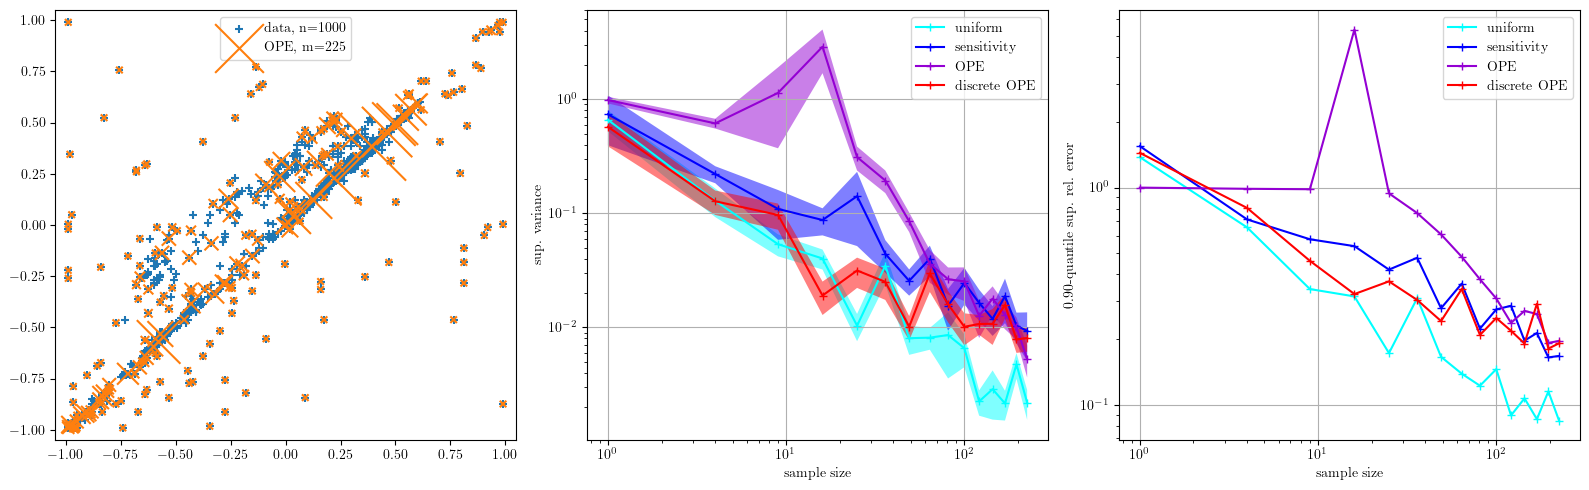

In [12]:
relerrs_sup, SE_means_sup, SE_stds_sup, = pickle_load(save_path)
OPE_samples, OPE_weights = samples_weights_list[2]

def my_plot():
    n_stds = 1*n_rep**(-.5) # number of standard deviations to plot
    xylim = 1.05

    plt.subplot(131), plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
    plt.scatter(X[:,0], X[:,1], marker="+", label=f"data, {n=}")
    X_samples, X_weights = X[OPE_samples[0]], 100*ms[-1]*OPE_weights[0]
    plt.scatter(X_samples[:,0],X_samples[:,1], marker="x", label=f"OPE, m={ms[-1]}", s=X_weights)
    plt.legend()

    plt.subplot(132)
    # draw from samplers, experimenting for any datasets
    legends = ["uniform","sensitivity","OPE","discrete OPE"]
    selector = range(len(legends))
    
    colors = ["cyan","blue","darkviolet","red","orange","maroon"]
    # cmap = plt.get_cmap('viridis') # viridis, magma
    # colors = cmap(np.linspace(0,.9,len(legends)))[::-1]
    plt.gca().set_prop_cycle(color=colors)
    plt.plot(ms, SE_means_sup[:,selector], label=legends, marker="+")
    for k in selector:
        plt.fill_between(ms, SE_means_sup[:,k]+n_stds*SE_stds_sup[:,k], SE_means_sup[:,k]-n_stds*SE_stds_sup[:,k], alpha=.5)
    plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel("sup. variance"), 
    plt.legend(), plt.grid()

    plt.subplot(133)
    delta_quant = .1 # .1, .01
    relerr_quant = np.quantile(relerrs_sup, 1-delta_quant, axis=-1)
    plt.gca().set_prop_cycle(color=colors)
    plt.plot(ms, relerr_quant[:,selector], label=legends, marker="+")
    plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel(f"{1-delta_quant:.2f}-quantile sup. rel. error")
    plt.legend(), plt.grid(),

# from interfaces import save_plots_interface
# save_plots_interface(my_plot, fig_size=(16,5), plot_on_call=True, use_TeX=True, font_size=14, fig_name=file_name)
plt.figure(figsize=(16,5))
my_plot()
plt.tight_layout()
plt.show()

# k-means

## Inspection

### Data generation

drawn lengths are: 1024, 1029, 1016, 1023, 1024, 1023, 

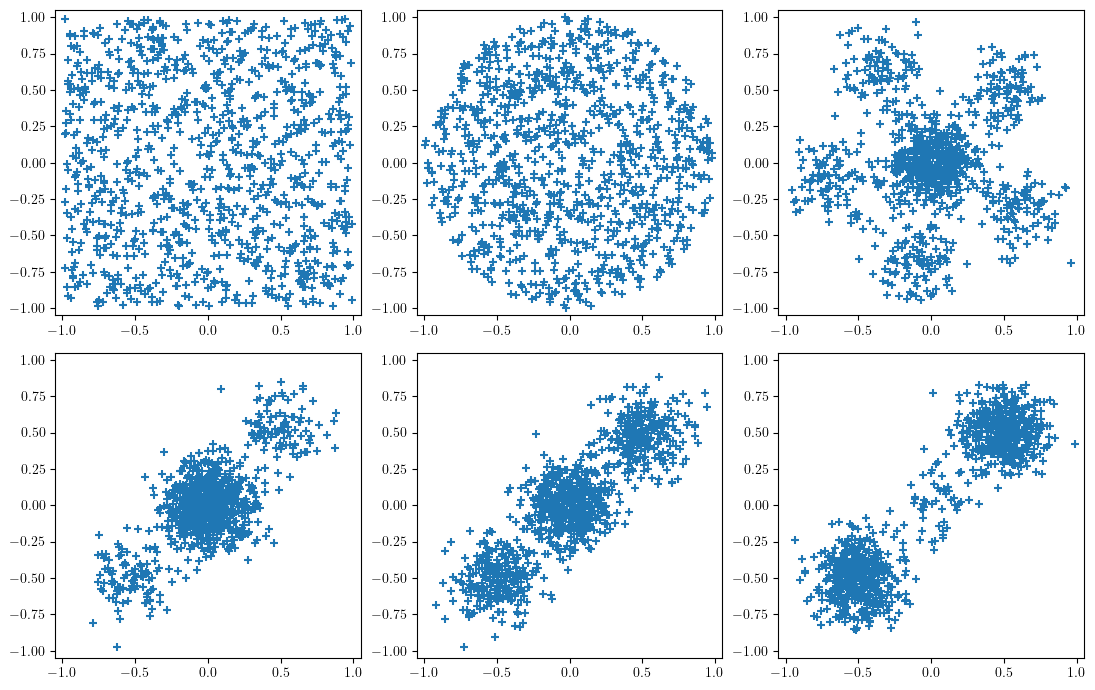

In [5]:
from utils import get_hypercube_data, get_circle_data, get_disk_data, get_corner_data

def draw_data(desired_n, d, k, prop_outliers=5/100, border=0.99):
    # generate data
    radius_corner = 0.5*2**.5
    X_uniform = get_hypercube_data(desired_n, d, border=border)
    # X_corner = get_corner_data(desired_n, d, k, border=border)
    X_disk = get_disk_data(desired_n, d, radius=1)
    X_kcent_knonout = get_circle_data(desired_n, d, k, border=border)
    X1 = get_circle_data(desired_n*(1-k*prop_outliers), d, k, 2, border=border)
    X2 = get_circle_data(desired_n*k*prop_outliers, d, k, border=border)
    X_kcent_2nonout = np.concatenate((X1, X2))
    X1 = get_circle_data(desired_n*(1-k*prop_outliers), d, k, 1, border=border)
    X2 = get_circle_data(desired_n*k*prop_outliers, d, k, border=border)
    X_kcent_1nonout = np.concatenate((X1, X2))
    X2 = get_circle_data(desired_n*(1-2*prop_outliers), d, 2, 1, border=border)
    X1 = get_circle_data(desired_n*2*prop_outliers, d, 2, border=border)
    X_outlier = np.concatenate((X1, X2))
    X1 = get_circle_data(desired_n/2, d, 5, border=border)
    X2 = get_circle_data(desired_n/2, d, 1, radius=0, variance=1/49, border=.99)
    X_5subbubbles = np.concatenate((X1, X2))
    X1 = get_circle_data(desired_n*20/100, d, 2, radius=radius_corner, variance=1/49, border=.99)
    X2 = get_circle_data(desired_n*80/100, d, 1, radius=0, variance=1/49, border=.99)
    X_2vs1_1 = np.concatenate((X1, X2))
    X1 = get_circle_data(desired_n/2, d, 2, radius=radius_corner, variance=1/49, border=.99)
    X2 = get_circle_data(desired_n/2, d, 1, radius=0, variance=1/49, border=.99)
    X_2vs1_2 = np.concatenate((X1, X2))
    X1 = get_circle_data(desired_n*95/100, d, 2, radius=radius_corner, variance=1/49, border=.99)
    X2 = get_circle_data(desired_n*5/100, d, 1, radius=0, variance=1/49, border=.99)
    X_2vs1_3 = np.concatenate((X1, X2))
    Xs = [X_uniform, X_disk, X_5subbubbles, X_2vs1_1, X_2vs1_2, X_2vs1_3]
    # Xs = [X_uniform, X_disk, X_outlier, X_kcent_knonout, X_kcent_2nonout, X_kcent_1nonout]
    print("drawn lengths are:", end=" ")
    for dataset in Xs:
        print(len(dataset), end=", ")
    return Xs

# plot
desired_n, d, k = 1024, 2, 3
Xs = draw_data(desired_n, d, k)
xylim = 1.05
plt.figure(figsize=(11,7)) # (12,5.5)
for i_plot, X_plot in enumerate(Xs):
    plt.subplot(2,int(np.ceil(len(Xs)/2)),i_plot+1), plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
    plt.scatter(X_plot[:,0], X_plot[:,1], marker="+")
plt.tight_layout(), plt.show();

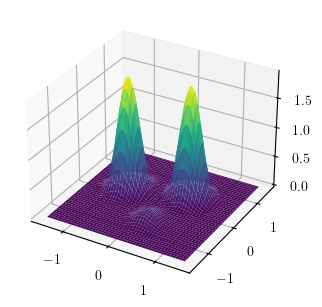

In [153]:
from sklearn.neighbors import KernelDensity
from interfaces import plot3d_func

# compute and plot KDE
kde = KernelDensity(kernel="epanechnikov", bandwidth="scott").fit(Xs[4])
gamma_tilde_pdf = lambda X: np.exp(kde.score_samples(X))
plt.figure(figsize=(8,4))
ax = plt.subplot(121, projection="3d")
plot3d_func(ax, gamma_tilde_pdf, 100)
plt.show();

### Sensitivity

In [154]:
from utils import get_true_sensit

# draw data with less datapoints because of latency 
# desired_n, d, k = 200, 2, 3
desired_n, d, k = 100, 2, 3
Xs = draw_data(desired_n, d, k)
Xs = np.array(Xs, dtype=object)[[0,2,3,4]]

# compute and plot sensitivity
sensits = []
for i_plot, X_plot in enumerate(Xs):
    sensits.append(get_true_sensit(X_plot, k))

drawn lengths are: 100, 97, 100, 98, 98, 100, 

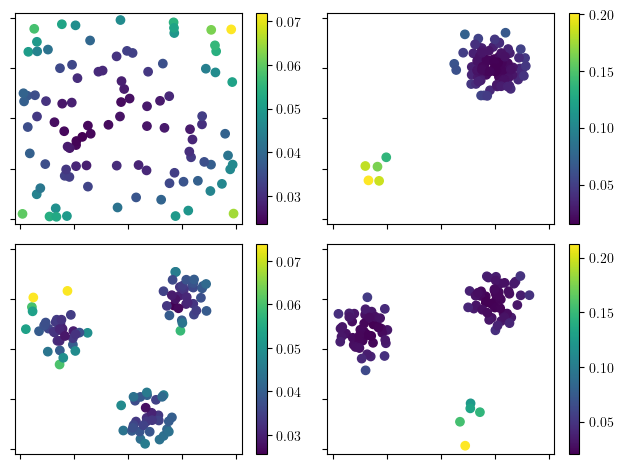

In [155]:
def my_plot():
    for i_plot, X_plot in enumerate(Xs):
        sensit = sensits[i_plot]
        plt.subplot(2,round(len(Xs)/2),i_plot+1), plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
        plt.scatter(X_plot[:,0], X_plot[:,1], c=sensit), plt.colorbar();
        plt.gca().set_xticklabels([]), plt.gca().set_yticklabels([])
my_plot()
plt.tight_layout()
plt.show()

### Sampling example

obtained n=300
/!\ OPE sampling and gamma_X is None
it will be KDE estimated, inducing n^2 complexity


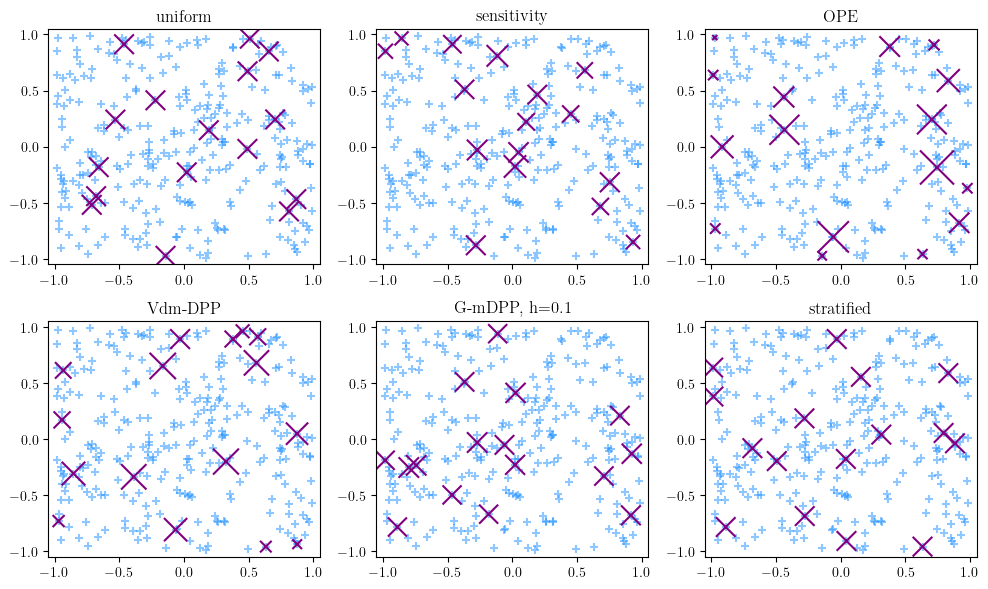

In [7]:
from samplers import draw_uniform, draw_sensitivity, draw_stratified, draw_gaussian_kDPP, draw_OPE, draw_discrete_OPE

# generate data
d, desired_n, m, k = 2, 300, 16, 5
n_samples = 1
radius_corner = 0.5*2**.5
X = get_hypercube_data(desired_n, d, border=.99)
n = len(X)
print(f"obtained {n=}")

# sample
samples_weights_list = []
samples_weights_list.append( draw_uniform(X, m, n_samples) )
samples_weights_list.append( draw_sensitivity(X, m, n_samples, k, delta=.1) )
samples_weights_list.append( draw_OPE(X, m, n_samples, prop_uniform=0) )
samples_weights_list.append( draw_discrete_OPE(X, m, n_samples) )
samples_weights_list.append( draw_gaussian_kDPP(X, m, n_samples, bandwidth=.1) )
samples_weights_list.append( draw_stratified(X, m, n_samples) )

# plot
titles = ["uniform","sensitivity","OPE","Vdm-DPP","G-mDPP, h=0.1","stratified"]
plt.figure(figsize=(10,6))
for k, (samples, weights) in enumerate(samples_weights_list):
    X_samples = X[samples]
    xylim = 1.05
    plt.subplot(2,len(titles)//2+len(titles)%2,k+1), plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
    plt.scatter(X[:,0], X[:,1], marker='+', alpha=.5, color="dodgerblue")
    for i_sample in range(n_samples):
        weight = None
        if weights is not None: 
            weight = 200*m*weights[i_sample]
        else: 
            weight = 200*m*np.ones(m)/m
        plt.scatter(X_samples[i_sample,:,0], X_samples[i_sample,:,1], marker="x", s=weight, color="purple")
    plt.title(titles[k])
    # plt.gca().set_xticklabels([]), plt.gca().set_yticklabels([])
plt.tight_layout(), 
plt.savefig("samplers_example.pdf")
plt.show();

### Variance and relative error rate

## Statistics

In [13]:
# from utils import get_hypercube_data, get_corner_data, get_circle_data
from samplers import draw_uniform, draw_sensitivity, draw_stratified, draw_gaussian_kDPP, draw_OPE, draw_discrete_OPE
from utils import loss, relative_error
# from interfaces import save_variables_interface
from sklearn.neighbors import KernelDensity

# data parameters
# d, desired_n, k = 2, 2**15, 3    # 2, 1024, 3
d, desired_n, k = 2, 2**10, 3    # 2, 1024, 3
# draw data
Xs = draw_data(desired_n, d, k)
X_names = ["X_uniform", "X_disk", "X_outlier", "X_kcent_knonout", "X_kcent_2nonout", "X_kcent_1nonout"]
i_dataset = 0 # choose the dataset index. 0 for uniform dataset.
X, X_name = Xs[i_dataset], X_names[i_dataset]

###############
# from utils import get_hypercube_data
# X = get_hypercube_data(desired_n, d=2, border=.99)
################
print(f"experimenting on {X.shape} dataset")
n = len(X)
print(f"obtained {n=}")

# repetitions parameters
# n_queries, n_rep = 50, 50 # 50, 500 / 100, 200 
# n_queries, n_rep = 200, 200 # 50, 500 / 100, 200 
# n_queries, n_rep = 100, 100 # 50, 500 / 100, 200 
n_queries, n_rep = 10, 10 # 50, 500 / 100, 200 
ms = np.arange(1,14, dtype=int)**2 # (1,14)
# ms = np.arange(13,14, dtype=int)**2 # (1,14)
print(f"m list={ms}")
bandwidths = [.01, .05, .10, .20, .30] # for uniform dataset
# prop_uniforms = [1., 0.5, 0.25, 0.12, 0.] # for uniform dataset

from utils import pickle_dump, pickle_load
save_dir = "./"
save_path = save_dir + f"X_unif_n{n}_m{ms[-1]}_3means_quer{n_queries}_rep{n_rep}.p"

# init queries
queries = X[np.random.choice(n, (n_queries,k), replace=False)] # np.zeros((1,1,X.shape[-1]))

# init OPE sampler by pre-computing KDE on data
kde = KernelDensity(kernel="epanechnikov", bandwidth="scott").fit(X)
kde_distr = np.exp(kde.score_samples(X))
# just draw from OPE to test and show in scatter plot
SE_means, SE_stds, relerrs = [], [], []
ab_coeff = generate_Jacobi_parameters(X)
print(ab_coeff)
OPE_samples, OPE_weights =  draw_OPE(X, ms[-1], 1, ab_coeff=ab_coeff, gamma_X=kde_distr)

drawn lengths are: 1024, 1022, 1020, 1023, 1023, 1023, experimenting on (1024, 2) dataset
obtained n=1024
m list=[  1   4   9  16  25  36  49  64  81 100 121 144 169]
Estimated beta distribution parameter is
 [[0.02782822 0.02153636]
 [0.04477642 0.04341682]]
[[0.02782822 0.02153636]
 [0.04477642 0.04341682]]


In [14]:
loss_Xs = []
for query in queries:
    # Evaluate the population loss
    # loss_X = loss(X, query) 
    loss_Xs.append(loss(X, query))
    
for m in ms:
    print(f"{m=}")
    # sample
    samples_weights_list = []

    # draw from samplers, experimenting for any datasets
    samples_weights_list.append( draw_uniform(X, m, n_rep) )
    samples_weights_list.append( draw_sensitivity(X, m, n_rep, k, delta=.1) )
    samples_weights_list.append( draw_OPE(X, m, n_rep, ab_coeff=ab_coeff, gamma_X=kde_distr, prop_uniform=0) )
    samples_weights_list.append( draw_discrete_OPE(X, m, n_rep) )
    # samples_weights_list.append( draw_gaussian_kDPP(X, m, n_rep, bandwidth=.1) )

    # draw from samplers, experimenting on uniform dataset only
    if i_dataset==0:
        print("drawing from samplers conveived for experimenting on uniform dataset only")
        samples_weights_list.append( draw_stratified(X, m, n_rep) )
        # for bandwidth in bandwidths:
        #     samples_weights_list.append( draw_gaussian_kDPP(X, m, n_rep, bandwidth=bandwidth) )
        # for prop_uniform in prop_uniforms:
        #     samples_weights_list.append( draw_OPE(X, m, n_rep, gamma_X=kde_distr, prop_uniform=prop_uniform) )
        
    # compute metrics for all samplers
    loss_samples = []
    for samples, weights in samples_weights_list:

        for loss_X, query in zip(loss_Xs, queries):
            # Evaluate the sample loss
            # loss_samples = loss(X, query, samples, weights)
            loss_samples = loss(X, query, samples, weights)

            # compute metrics
            SEs = (loss_samples - loss_X)**2
            SE_means.append(SEs.mean(-1))
            SE_stds.append(SEs.std(-1))
            relerrs.append(relative_error(loss_samples, loss_X))

# aggregate metrics
n_ms, n_samplers = len(ms), len(samples_weights_list)
relerrs_sup = np.reshape(relerrs, (n_ms, n_samplers, n_queries, n_rep)).max(2) # max on queries
SE_means, SE_stds = np.reshape(SE_means, (n_ms, n_samplers, n_queries)), np.reshape(SE_stds, (n_ms, n_samplers, n_queries))
SE_means_argmax = SE_means.argmax(2) # argmax on queries
arr1, arr2 = np.ogrid[:n_ms,:n_samplers]
SE_means_sup = SE_means[arr1, arr2, SE_means_argmax]
SE_stds_sup = SE_stds[arr1, arr2, SE_means_argmax]

pickle_dump([relerrs_sup, SE_means_sup, SE_stds_sup], save_path)

m=1
drawing from samplers conveived for experimenting on uniform dataset only
m=4
drawing from samplers conveived for experimenting on uniform dataset only
m=9
drawing from samplers conveived for experimenting on uniform dataset only
m=16
drawing from samplers conveived for experimenting on uniform dataset only
m=25
drawing from samplers conveived for experimenting on uniform dataset only
m=36
drawing from samplers conveived for experimenting on uniform dataset only
m=49
drawing from samplers conveived for experimenting on uniform dataset only
m=64
drawing from samplers conveived for experimenting on uniform dataset only
m=81
drawing from samplers conveived for experimenting on uniform dataset only
m=100
drawing from samplers conveived for experimenting on uniform dataset only
m=121
drawing from samplers conveived for experimenting on uniform dataset only
m=144
drawing from samplers conveived for experimenting on uniform dataset only
m=169
drawing from samplers conveived for experiment

hey


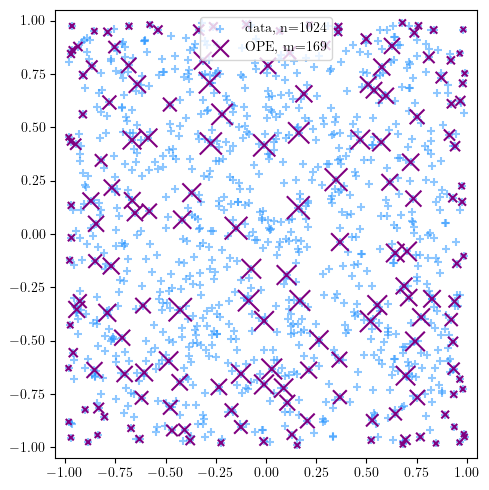

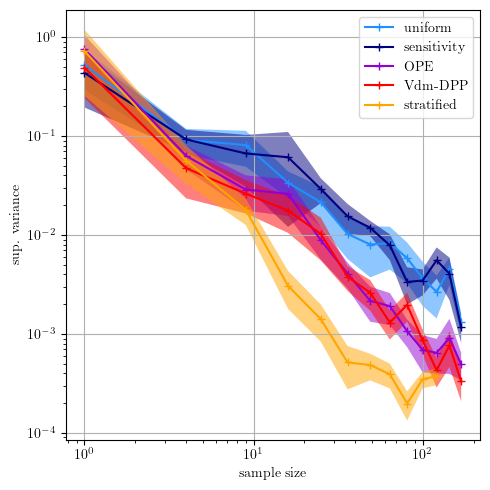

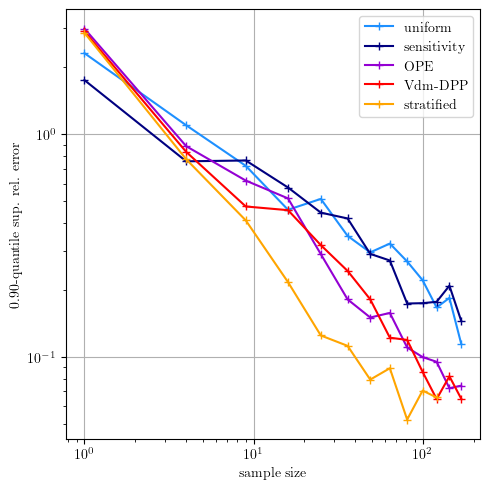

In [15]:
# save_path = "/feynman/home/dphp/hs276503/workspace/DPPcoresets_proj/X_unif_n32768_m169_3means_quer100_rep100.p"
relerrs_sup, SE_means_sup, SE_stds_sup, = pickle_load(save_path)
prefix = "unif_2p10_3"

def my_plot():
    n_stds = 1*n_rep**(-.5) # number of standard deviations to plot
    xylim = 1.05

    # plt.subplot(131)
    plt.figure(figsize=(5,5))
    plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
    plt.scatter(X[:,0], X[:,1], marker="+", label=f"data, {n=}", alpha=0.5, color='dodgerblue')
    X_samples, X_weights = X[OPE_samples[0]], 100*ms[-1]*OPE_weights[0]
    plt.scatter(X_samples[:,0],X_samples[:,1], marker="x", label=f"OPE, m={ms[-1]}", color='purple', s=X_weights)
    plt.legend(), plt.tight_layout()
    plt.savefig(prefix+"_OPE.pdf")


    # plt.subplot(132)
    plt.figure(figsize=(5,5))
    # draw from samplers, experimenting for any datasets
    legends = ["uniform","sensitivity","OPE","Vdm-DPP","G-mDPP, h=0.1"][:-1]
    selector = range(len(legends))

    # # draw from samplers, experimenting on uniform dataset only
    if i_dataset==0:
        legends += ["stratified"]
        legends += [f"G-DPP, h={bandwidth:.2f}" for bandwidth in bandwidths]
    #     legends += [f"prop unif={prop_uniform:.2f}" for prop_uniform in prop_uniforms]
        # selector_uniform_samplers = [0,1,2,3,4,5]
        selector_uniform_samplers = [0,1,2,3,4]
        selector_uniform_gkdpp = [0,6,7,8,9,10]
    #     selector_uniform_propunif = [11,12,13,14,15]
    #     ##### choose one selector #####
        selector = selector_uniform_samplers
    #     # selector = selector_uniform_gkdpp
    #     # selector = selector_uniform_propunif
        legends = np.array(legends)[selector]
    
    colors = ["dodgerblue","navy","darkviolet","red","orange","maroon"]
    # colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown']
    # cmap = plt.get_cmap('viridis') # viridis, magma
    # colors = cmap(np.linspace(0,.9,len(legends)))[::-1]
    plt.gca().set_prop_cycle(color=colors)
    plt.plot(ms, SE_means_sup[:,selector[:-1]], label=legends[:-1], marker="+")
    # plt.plot(ms, SE_means_sup[:,selector], label=legends, marker="+")
    for k in selector:
        if k ==4:
            plt.plot(ms[:-2], SE_means_sup[:-2,k], label=legends[k], marker="+")
            print("hey")
            plt.fill_between(ms[:-2], SE_means_sup[:-2,k]+n_stds*SE_stds_sup[:-2,k], SE_means_sup[:-2,k]-n_stds*SE_stds_sup[:-2,k], alpha=.5)
        else:
            plt.fill_between(ms, SE_means_sup[:,k]+n_stds*SE_stds_sup[:,k], SE_means_sup[:,k]-n_stds*SE_stds_sup[:,k], alpha=.5)
    plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel("sup. variance"), 
    plt.legend(), plt.grid(), plt.tight_layout()
    plt.savefig(prefix+"_var.pdf")

    # plt.subplot(133)
    plt.figure(figsize=(5,5))
    delta_quant = .1 # .1, .01
    relerr_quant = np.quantile(relerrs_sup, 1-delta_quant, axis=-1)
    plt.gca().set_prop_cycle(color=colors)
    # plt.plot(ms, relerr_quant[:,selector], label=legends, marker="+")
    plt.plot(ms, relerr_quant[:,selector[:-1]], label=legends[:-1], marker="+")
    plt.plot(ms[:-2], relerr_quant[:-2,4], label=legends[4], marker="+")
    plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel(f"{1-delta_quant:.2f}-quantile sup. rel. error")
    plt.legend(), plt.grid(), plt.tight_layout()
    plt.savefig(prefix+"_relerr.pdf")

# plt.figure(figsize=(16,5))
my_plot()
plt.tight_layout()
plt.show()

### Power regression

In [17]:
from sklearn.linear_model import LinearRegression

def power_regression(x, y):
    logx, logy = np.log(x)[:,None], np.log(y)
    reg = LinearRegression().fit(logx, logy)
    power, factor = reg.coef_, np.exp(reg.intercept_)
    R_squared = reg.score(logx, logy)
    return power, factor, R_squared

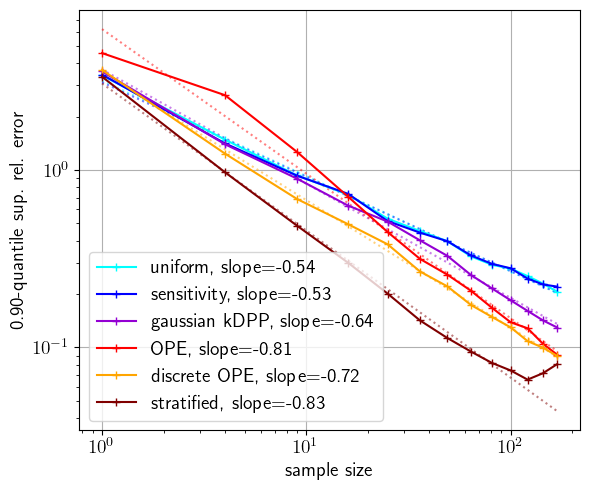

interactive(children=(FloatSlider(value=6.0, continuous_update=False, description='fig_width', max=20.0, min=4…

interactive(children=(Text(value='./figs/', description='fig_directory'), Text(value='X_uniform_n1024_m169_3me…

In [48]:
def my_plot():
    k_start, k_end = 0, None
    legends = ["uniform","sensitivity","gaussian kDPP","OPE","discrete OPE","stratified"]
    selector = range(len(legends))
    colors = ["cyan","blue","darkviolet","red","orange","maroon"]
    plt.gca().set_prop_cycle(color=colors)

    plt.subplot(111)
    delta_quant = .1 # .1, .01
    relerr_quant = np.quantile(relerrs_sup, 1-delta_quant, axis=-1)
    plt.gca().set_prop_cycle(color=colors)
    for k in selector:
        if k==5:
            k_end = -2
        power, factor, R_squared = power_regression(ms[k_start:k_end], relerr_quant[k_start:k_end,k])
        plt.plot(ms, factor*ms**power, ":", alpha=0.5)
        legends[k] += f", slope={power[0]:.2f}"

    plt.plot(ms, relerr_quant[:,selector], label=legends, marker="+")
    plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel(f"{1-delta_quant:.2f}-quantile sup. rel. error")
    plt.legend(), plt.grid(),

from interfaces import save_plots_interface
save_plots_interface(my_plot, fig_size=(6,5), plot_on_call=True, use_TeX=True, font_size=14, fig_name=file_name)

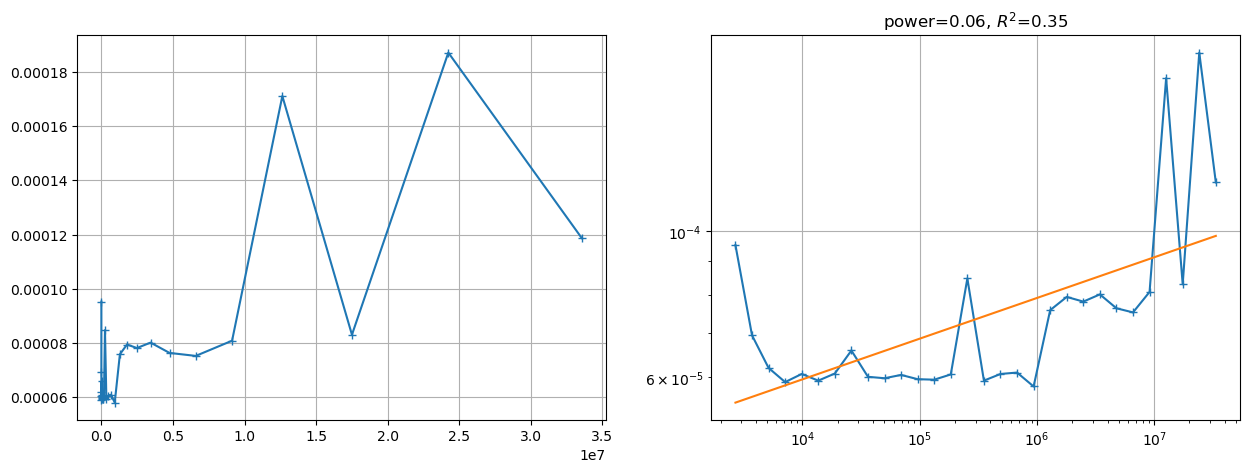

In [27]:
from sklearn.linear_model import LinearRegression

def power_regression(x, y):
    plt.subplot(121)
    plt.plot(x, y, marker="+"), plt.grid()
    logx, logy = np.log(x)[:,None], np.log(y)
    reg = LinearRegression().fit(logx, logy)
    power, factor = reg.coef_, np.exp(reg.intercept_)
    R_squared = reg.score(logx, logy)
    
    plt.subplot(122)
    plt.plot(x, y, marker="+")
    plt.plot(x, np.exp(reg.predict(logx)))
    plt.xscale('log'), plt.yscale('log')
    plt.title(f"power={power[0]:.2f}, $R^2$={R_squared:.2f}"), plt.grid();
    return reg

k_start = 20
plt.figure(figsize=(15,5))
fitted_reg = power_regression(n_list[k_start:], elapsed_times[k_start:])

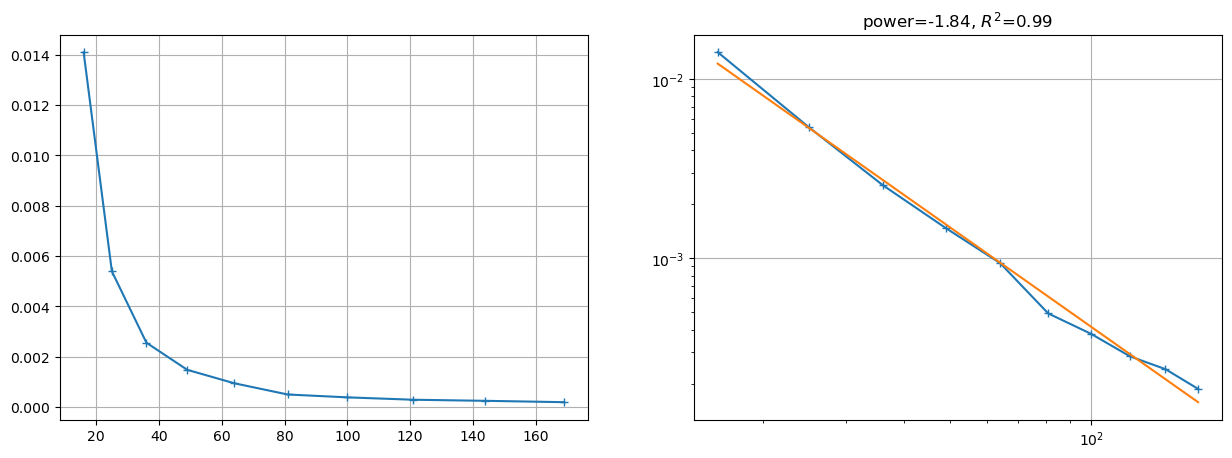

In [44]:
k_start, k_end = 3, None
plt.figure(figsize=(15,5))
fitted_reg = power_regression(ms[k_start:k_end], SE_means[:,2][k_start:k_end])

### Benchmark DPPy sample_exact

In [26]:
from timeit import default_timer as timer
elapsed_times = []
n_list = []
d, n, nb_rep = 2, 2000, 10
ns = np.round(np.logspace(2, 25, num=50, base=2)).astype(int) # 20
# ns = np.arange(1, 30)**4
print(ns)
ab_coeff = 0
ab_coeff_array = np.zeros((d,2)) + ab_coeff
for n in ns:
    print(f"n={n}")
    start_time = timer()
    for rep in range(nb_rep):
        # X = get_hypercube_data(n, d)
        # obtain P which decompose continuous DPP K = PP^T
        # dpp = MultivariateJacobiOPE(m, ab_coeff_array)
        # polynom_X = dpp.eval_multiD_polynomials(X)
        # eig_vals, eig_vecs, weights = draw_OPE(X, int(m), gamma_X=.25)
        # OPE_samples = get_DPP_samples(eig_vals[:m], eig_vecs[:,:m], n_samples=2)
        # gamma_tilde = stats.gaussian_kde(X.T)
        # gamma_X = gamma_tilde.pdf(X.T)
        truc= np.round(n*np.random.rand(nb_rep))
    n_list.append(n)
    elapsed_times.append(timer() - start_time)

[       4        6        8       11       15       20       28       39
       54       75      104      143      198      275      380      527
      729     1010     1398     1935     2680     3710     5136     7111
     9846    13632    18874    26131    36179    50090    69351    96018
   132939   184057   254831   352820   488487   676320   936380  1296439
  1794947  2485144  3440736  4763774  6595549  9131681 12643011 17504524
 24235395 33554432]
n=4
n=6
n=8
n=11
n=15
n=20
n=28
n=39
n=54
n=75
n=104
n=143
n=198
n=275
n=380
n=527
n=729
n=1010
n=1398
n=1935
n=2680
n=3710
n=5136
n=7111
n=9846
n=13632
n=18874
n=26131
n=36179
n=50090
n=69351
n=96018
n=132939
n=184057
n=254831
n=352820
n=488487
n=676320
n=936380
n=1296439
n=1794947
n=2485144
n=3440736
n=4763774
n=6595549
n=9131681
n=12643011
n=17504524
n=24235395
n=33554432


In [25]:
np.random.choice(n, nb_rep), np.random.rand(n, nb_rep).shape

(array([20451574,  6466630, 30246717, 25200919,  1867114, 11104117,
         2257348, 16958323,  4892921, 30294148]),
 (33554432, 10))